In [296]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

sys.path.insert(0, '../') 
print(sys.path)
from utils.readProfiles import *
from utils.global_variables import ABRVS
from utils.general import write_dataframe_to_excel
from scripts.classify_moa import get_moa_dirname,exp_results_to_csv

['../', '../', '/sise/home/alonshp/AnomalyDetectionScreening', '/sise/home/alonshp/AnomalyDetectionScreening/notebooks', '../', '/sise/home/alonshp/AnomalyDetectionScreening/notebooks', '/sise/home/alonshp/AnomalyDetectionScreening/notebooks', '/home/alonshp/AnomalyDetectionScreening/ads', '/home/alonshp/.conda/envs/pytorch_ads/lib/python310.zip', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/lib-dynload', '', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages', '/tmp/tmpj1cg8ac4']


## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average

### Paths

In [360]:
from datetime import datetime
import os

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='CDRP-bio'
dataset='LINCS'
exp_name = '2003_t'
# exp_name = '2142'
# exp_name = 'interpret_2603'
# exp_name = 'final_184_t'

filter_groups = ['CP', 'anomaly','l1k']
# filter_groups = ['CP','l1k']
ref_filter_groups = ['CP','l1k']
moa_exp_dir = 'MoAprediction'

tune = True
tune_all_folds = True
normalize_by_all=True

if tune:
    if tune_all_folds:
        tune_str = '-ta'
    else:
        tune_str = '-t'
else:
    tune_str = ''

res_filename=f'pred_moa_res_all'

modality = 'CellPainting'
################################################


profile_type='augmented'
folds = 5
rep_corr_fileName='RepCorrDF'

base_dir='/sise/assafzar-group/assafzar/genesAndMorph'
res_dir = f'{base_dir}/results/'
exp_dir = f'{base_dir}/results/{dataset}/{modality}/{exp_name}'
moa_exp_dir = f'{exp_dir}/{moa_exp_dir}/'

data_dir = f'{base_dir}/anomaly_output/{dataset}/CellPainting/{exp_name}' 

# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/preprocessed_data
# aws s3 sync preprocessed_data s3://cellpainting-datasets/Rosetta-GE-CP/preprocessed_data --profile jumpcpuser

if dataset=='CDRP-bio':
    # exp_name = '2011_t'
    nSamplesMOA=4
    by_dose = False
elif dataset=='LINCS':
    # exp_name = '2011_32_t'
    nSamplesMOA=4
    by_dose = False 

profTypeAbbrev=''.join([s[0] for s in profile_type.split('_')])
Types = ['ae_diff', 'baseline']
profileTypes = [f'{profile_type}_{t}' for t in Types]
profTypeAbbrev = [ABRVS[p] for p in profileTypes]

profiles = {}
for p in profileTypes:
    profiles[p] = {}
    profiles[p]['cp_path'] = os.path.join(data_dir,f'replicate_level_cp_{p}.csv')
    
# filename='../../results/RepCor/'+fileName+'.xlsx'
# os.makedirs(procProf_dir,exist_ok=True)

### Read GE and CP profiles 

In [361]:
moa_csv_dirname, exp_suffix, filter_abrv = get_moa_dirname(profile_type, by_dose, filter_groups, folds, nSamplesMOA, normalize_by_all)

save_dir = os.path.join(moa_exp_dir,moa_csv_dirname)

exp_results_to_csv(exp_dir, moa_csv_dirname, filename=res_filename)

fig_dir = f'{moa_exp_dir}/figures/'
# os.makedirs(save_dir,exist_ok=True)
os.makedirs(fig_dir,exist_ok=True)
save_dir

'/sise/assafzar-group/assafzar/genesAndMorph/results/LINCS/CellPainting/2003_t/MoAprediction/augmented_n4_f5_a_ba_cal'

## Visualize the results

In [362]:
moa_csv_dirname

'augmented_n4_f5_a_ba_cal'

In [363]:
filename = f'{save_dir}/{res_filename}.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
sgkf_keys_all = saved_scores_cdrpbio.keys()

In [364]:
sgkf_keys_all

dict_keys(['Anomaly-lr-ta', 'Anomaly-mlp-ta', 'CellProfiler-lr-ta', 'CellProfiler-mlp-ta', 'fuse-lr-ta', 'fuse-mlp-ta'])

In [365]:

# saved_scores_cdrpbio[sgkf_keys[0]]
# sgkf_keys
# methods.keys()
sgkf_keys = []
if tune:
    sgkf_keys = [s for s in sgkf_keys_all if '-t'  in s]
    if tune_all_folds:
        sgkf_keys = [s for s in sgkf_keys_all if '-ta'  in s]
    else:
        sgkf_keys = [s for s in sgkf_keys_all if not '-ta'  in s]
else:
    sgkf_keys = [s for s in sgkf_keys_all if not '-t'  in s]
sgkf_keys

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

In [366]:
for key in saved_scores_cdrpbio.keys():
    print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
# saved_scores_cdrpbio['raw_a-lr'].shape

num values for Anomaly-lr-ta is 4680
num values for Anomaly-mlp-ta is 4680
num values for CellProfiler-lr-ta is 4680
num values for CellProfiler-mlp-ta is 4680
num values for fuse-lr-ta is 4680
num values for fuse-mlp-ta is 4680


In [367]:
def compute_f1(df,model_name,data_type,e,f=None):
    # f1 = f1_score(df['Metadata_moa_num'].tolist(),df['Late Fusion'].tolist(), average='weighted')
    # df = df.rename(columns={'GE':'L1000','CP':'CellPainting','Late Fusion':'CellPainting+L1000'})
    df.rename(columns={'GE':'L1000','CP':'-L1000','Late Fusion':'+L1000'},inplace=True)
    # , 'Early Fusion': 'CellPainting+L1000'},inplace=True)
    modalities= ['-L1000','+L1000']
    modalities= ['L1000', '-L1000','+L1000']

    # output_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    output_df = pd.DataFrame([])

    for dd in modalities:
        scor_vals=df[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        # print(f'data type: {data_type}, model: {model_name}, modality: {dd}, fold: {f}')
        f1_macro=f1_score(scor_vals,df.Metadata_moa_num.values, average='macro')
        f1_weighted=f1_score(scor_vals,df.Metadata_moa_num.values, average='weighted')

        if f is not None:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'Fold':[f],'exp_num':[e]})
        else:
            temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': [model_name],'F1-macro':[f1_macro],'F1-weighted':[f1_weighted],'Type':[data_type],'exp_num':[e]})
        output_df = pd.concat([output_df,temp_df])
    return output_df

def concat_model_scores(df,model_name='MLP',data_type='AE'):
    # methods= ['CP', 'GE', 'Early Fusion','Late Fusion']
    folds=df['Fold'].unique().tolist()
    exps = df['exp_num'].unique().tolist()
    res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num'])
    res_df_fold_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
    for e in exps:
        df_e = df[df['exp_num']==e]
        temp_df = compute_f1(df_e,model_name,data_type,e)
        res_df_exp_level=pd.concat([res_df_exp_level,temp_df])
        # res_df_by_exp
        for f in folds:
            df_f=df_e[df_e['Fold']==f]
            temp_df = compute_f1(df_f,model_name,data_type,e,f)
            res_df_fold_level=pd.concat([res_df_fold_level,temp_df])
                    #    ,'RGCCA_EarlyFusion']:
                
                # res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
                
    return res_df_fold_level, res_df_exp_level       


In [368]:
sgkf_keys

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

In [369]:
from sklearn.metrics import f1_score
#########################################################
res_df =pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','Fold','exp_num'])

# DS='CDRP-bio'
# scores_mlp=saved_scores_cdrpbio[DS+'-nvs-mlp-ht-sgkf-10f']
# scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
reps = ['CellProfiler', 'Anomaly', 'Fusion']
methods = ['lr', 'mlp']

# res_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
for i ,k in enumerate(sgkf_keys):
    # data_representation = k.split('-')[0]
    # m = methods[i]
    if 'Anomaly' in k:
        data_representation = reps[1]
    elif 'CellProfiler' in k: 
        data_representation = reps[0]
    else:
        data_representation= reps[2]

    if 'mlp' in k:
        model = 'MLP'
    elif 'lr' in k: 
        model = 'LR'
    elif 'xgboost' in k:
        model = 'XGBoost'
    print(model)
    print(data_representation)
    res_df_method, res_df_exp_level_method = concat_model_scores(saved_scores_cdrpbio[k], model,data_type = data_representation) 
    res_df = pd.concat([res_df,res_df_method])
    res_df_exp_level = pd.concat([res_df_exp_level,res_df_exp_level_method])
    
n_classes = saved_scores_cdrpbio[k].Metadata_moa_num.nunique()


LR
Anomaly



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

MLP
Anomaly



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

LR
CellProfiler



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

MLP
CellProfiler



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

LR
Fusion



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

MLP
Fusion



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [370]:
saved_scores_cdrpbio[k]

,CP,GE,Early Fusion,Late Fusion,Metadata_moa_num,PERT,Metadata_moa_with_n,Compounds,Fold,exp_num
0,31,50,27,27,26,BRD-A02006392,calcium channel blocker (n=12),BRD-A02006392,1,5
1,7,10,10,10,10,BRD-A03506276,HSP inhibitor (n=5),BRD-A03506276,2,5
2,21,48,48,48,1,BRD-A04352665,CC chemokine receptor antagonist (n=5),BRD-A04352665,3,5
3,29,28,28,28,34,BRD-A04553218,histamine receptor antagonist (n=18),BRD-A04553218,4,5
4,53,53,53,53,53,BRD-A05821830,tubulin polymerization inhibitor (n=8),BRD-A05821830,5,5
...,...,...,...,...,...,...,...,...,...,...
4675,47,52,16,47,52,BRD-K99475619,topoisomerase inhibitor (n=13),BRD-K99475619,2,0
4676,50,38,38,38,41,BRD-K99604664,progesterone receptor agonist (n=6),BRD-K99604664,5,0
4677,25,53,14,14,39,BRD-K99792991,potassium channel activator (n=6),BRD-K99792991,3,0
4678,30,23,30,30,30,BRD-M80207679,dopamine receptor antagonist (n=14),BRD-M80207679,1,0


In [371]:
saved_scores_cdrpbio.keys()

dict_keys(['Anomaly-lr-ta', 'Anomaly-mlp-ta', 'CellProfiler-lr-ta', 'CellProfiler-mlp-ta', 'fuse-lr-ta', 'fuse-mlp-ta'])

In [372]:

sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":16,"axes.labelsize":16})
pallete= "Set2"
sns.color_palette(pallete)
sns.set(style="whitegrid", palette=pallete)

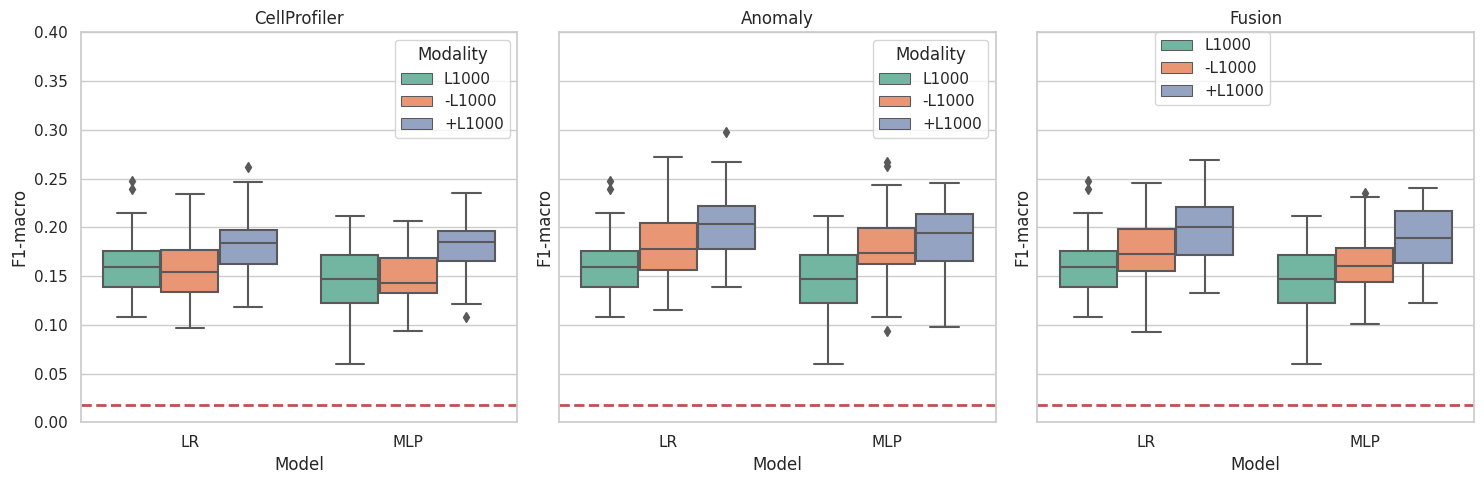

In [373]:

n_cols = len(reps)
fig,axes=plt.subplots(1,n_cols,figsize=(5*n_cols,5),sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(reps):
    # p_abrv = p.split('_')[0]
    # print(p_abrv)
    sns.boxplot(x="Model", y="F1-macro", hue="Modality", data=res_df[res_df["Type"]==p],ax=axes[i])#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)
    # sns.set_palette(pallete)
    
    axes[i].set_ylim(0,0.4)
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()

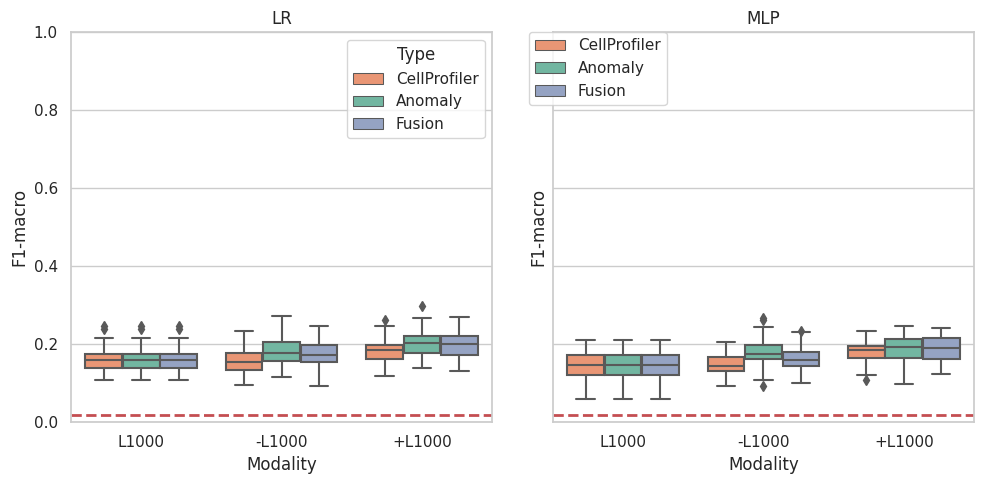

In [374]:
# res_df_cdrpbio
import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# pallete2 = sns.color_palette("Set2")
# pallete2
pallete3 = [sns.color_palette("Set2")[1],sns.color_palette("Set2")[0],sns.color_palette("Set2")[2]]
# palette
sns.set(style="whitegrid", palette=pallete3)
# sns.set_style("whitegrid")
methods = ['AnomalyCP','CP']
models = ['LR','MLP','XGBoost']
models = ['LR','MLP']
hue_order = ['CellProfiler','Anomaly', 'Fusion']

Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    sns.boxplot(x="Modality", y="F1-macro", hue="Type", data=res_df[res_df["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,1)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper right', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'moa_all_modalities_bar_{moa_csv_dirname}.png')
plt.savefig(save_path,dpi=500)

In [375]:
res_df_grouped_folds = res_df.groupby(['Model','Modality','Type','exp_num']).mean().reset_index()

# sns.set_style("whitegrid")
# fig,axes=plt.subplots(1,1,figsize=(5,5),sharey=True)
methods = ['CellProfiler','Anomaly', 'Fusion']
methods = ['CellProfiler','Anomaly']
hue_order = methods
models = ['LR','MLP']
# Modalities = ['CP', 'GE', 'Early Fusion']
modality = '-L1000'

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# for i,p in enumerate(models):


In [376]:
res_df_grouped_folds.sort_values(by='F1-weighted',ascending=True,inplace=True)

In [377]:
# filter out methods not inspected
res_df_grouped_folds = res_df_grouped_folds[res_df_grouped_folds['Type'].isin(methods)].reset_index(drop=True)
# res_df_grouped_folds

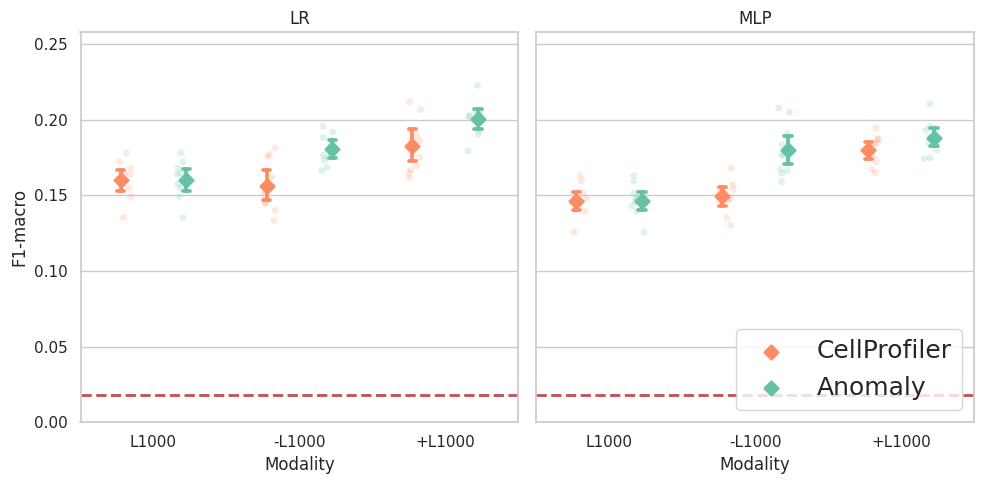

In [378]:
from utils.global_variables import methods_colors_list_for_moa
# methods = ['AnomalyCP','CP']
# models = ['LR','MLP']
order = ['L1000','-L1000', '+L1000']

metric = 'F1-macro'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    order = order
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    order = order
    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
    axes[i].legend(loc = 'lower right', fontsize = 18)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_dirname}_{metric}.png')
plt.savefig(save_path,dpi=500)

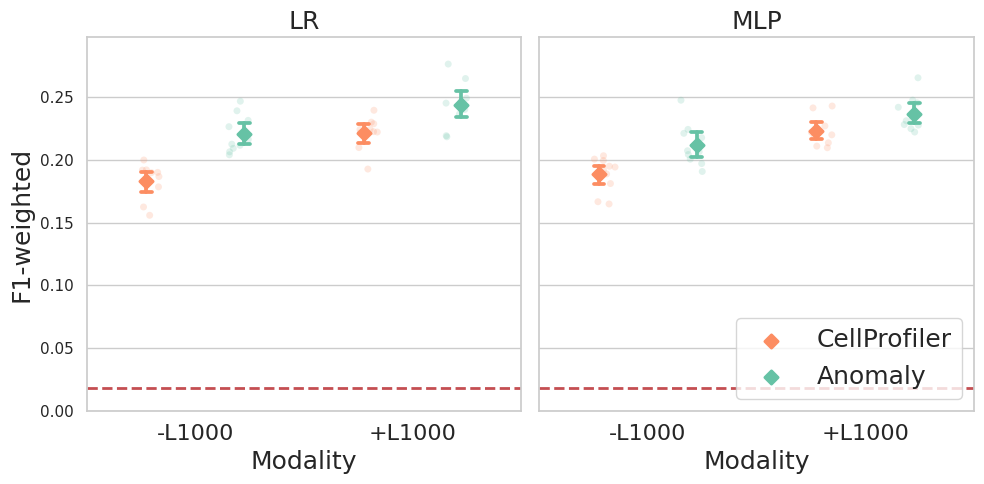

In [379]:
# res_df_cdrpbio
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set(style="whitegrid", palette=pallete)
# sns.set_style("whitegrid")

# methods = ['AnomalyCP','CP']
# models = ['LR','MLP']

order = ['-L1000', '+L1000']
metric = 'F1-weighted'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    # order = ['L1000','CP', 'CP+L1000']
    order = order
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    # order = ['L1000','CP', 'CP+L1000']
    order = order

    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p, fontsize=18)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
    # g.legend(loc = 'lower right', borderaxespad=0, fontsize=16)

    # set font size for labels 
    axes[i].set_xlabel(axes[i].get_xlabel(),fontsize=18)
    axes[i].set_ylabel(axes[i].get_ylabel(),fontsize=18)
    axes[i].set_xticklabels(axes[i].get_xticklabels(),fontsize=16)
    axes[i].legend(fontsize=18,loc = 'lower right')

    
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False, fontsize=20, loc='lower right')
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_dirname}_{metric}.png')
plt.savefig(save_path,dpi=500)

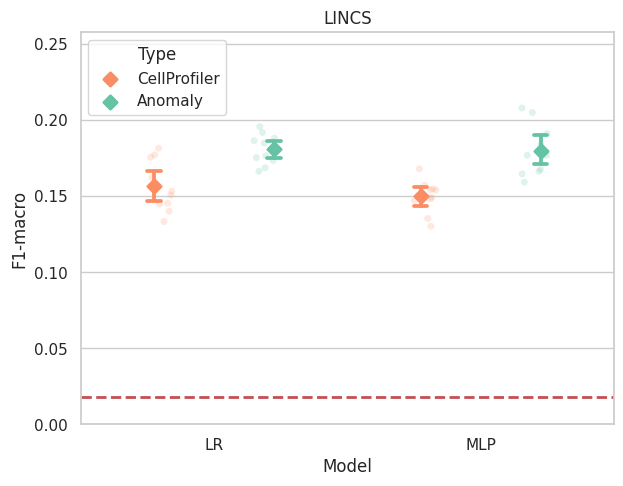

In [380]:
# res_df_grouped_folds.groupby(['Model','Modality','Type'])['F1-macro'].describe()
# res_df_grouped_folds
metric = 'F1-macro'
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, order = ['LR','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, order = ['LR','MLP']
    # markerssize=20, markersedgewidth=3,
)
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend( loc='lower right', borderaxespad=0)
# g.legend(loc='upper right', bbox_to_anchor=(0.6, 0.1))
# g.legend(loc='upper right')

# g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)

g.set_ylim(0,max_val+0.05)
plt.tight_layout()
plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}.png')
plt.savefig(save_path,dpi=500)

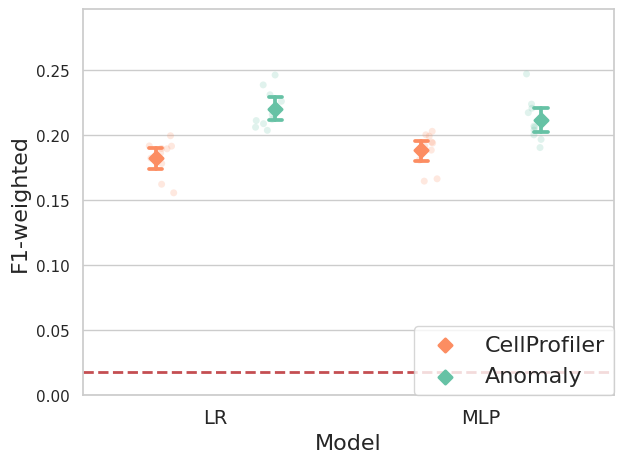

In [381]:
########### w/o Fusion #############
metric = 'F1-weighted'

res_df_grouped_folds_no_fusion = res_df_grouped_folds[res_df_grouped_folds['Type']!='Fusion']

max_val = res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=['CellProfiler', 'Anomaly'], order = ['LR','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=['CellProfiler', 'Anomaly'], order = ['LR','MLP']
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0,max_val+0.05)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=16)

# set font size for labels 
g.set_xlabel(g.get_xlabel(),fontsize=16)
g.set_ylabel(g.get_ylabel(),fontsize=16)
g.set_xticklabels(g.get_xticklabels(),fontsize=14)
# plt.ylabel(fontsize=16)
# plt.xticks(fontsize=16)
plt.tight_layout()
# plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}_no_fusion.png')
plt.savefig(save_path,dpi=500)

LR
10
10
Welch's t-test results:
t-statistic: 3.9229941700518776
p-value: 0.0014116214447404832


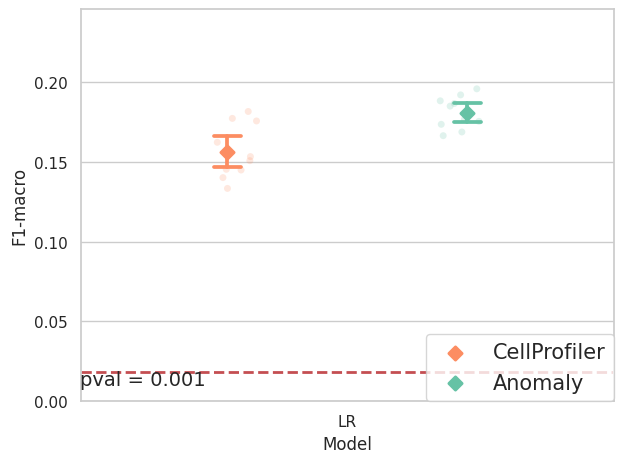

MLP
10
10
Welch's t-test results:
t-statistic: 4.74450859407919
p-value: 0.0002468987243017962


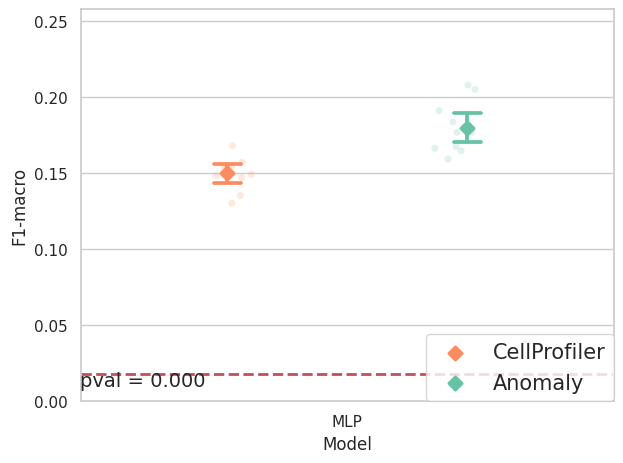

Welch's t-test results:
t-statistic: 6.627661019839207
p-value: 3.2906472072330617e-06
LR
10
10
Welch's t-test results:
t-statistic: 5.849919111206073
p-value: 1.555444288644715e-05


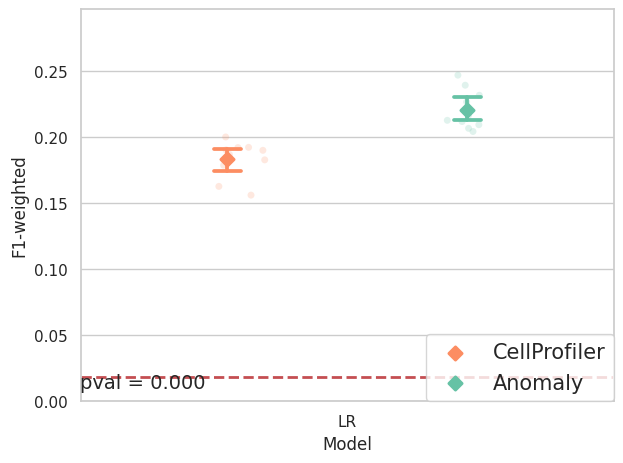

MLP
10
10
Welch's t-test results:
t-statistic: 3.416415240086104
p-value: 0.003207008848140534


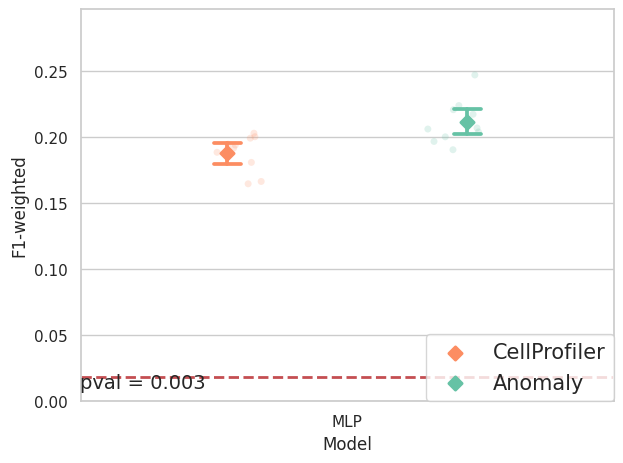

Welch's t-test results:
t-statistic: 5.015950025771206
p-value: 9.130320070166338e-05


<Figure size 640x480 with 0 Axes>

In [382]:
########### only MLP #############
from scipy.stats import ttest_ind


metrics = ['F1-macro','F1-weighted']
for metric in metrics:
    for model in models:
        print(model)
        res_df_grouped_folds_mlp = res_df_grouped_folds[(res_df_grouped_folds['Model']==model) & (res_df_grouped_folds["Modality"]==modality)]

        # metric = 'F1-weighted'
        max_val = res_df_grouped_folds_mlp.groupby(['Model','Type'])[metric].max().max()

        sns.stripplot(
            data=res_df_grouped_folds_mlp, x="Model", y=metric, hue="Type",
            dodge=True, alpha=.2, legend=False,hue_order=['CellProfiler', 'Anomaly'],
        )
        g =sns.pointplot(
            data=res_df_grouped_folds_mlp, x="Model", y=metric, hue="Type",
            dodge=.45, 
            linestyles="none", 
            errorbar=("ci", 95), capsize=.05,
            markers="D",hue_order=['CellProfiler', 'Anomaly']
            # markerssize=20, markersedgewidth=3,
        )

        g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
        g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)
        g.set_ylim(0,max_val+0.05)

        # Extract the data for 'CellProfiler' and 'Anomaly'
        data_cellprofiler = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'CellProfiler'][metric]
        data_anomaly = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'Anomaly'][metric]

        print(len(data_cellprofiler))
        print(len(data_anomaly))
        
        # Perform Welch's t-test
        t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

        # Print the results
        print("Welch's t-test results:")
        print(f"t-statistic: {t_stat}")
        print(f"p-value: {p_value}")


        plt.tight_layout()
        # plt.title(f'{dataset}_pval = {p_value:.3f}')
        plt.text(-0.5, 0.01, f'pval = {p_value:.3f}', fontsize=14)
        save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_dirname}_{model}_only.png')
        plt.show()
        plt.savefig(save_path,dpi=500)
        # plt.close()

    # calc p_value between different models
    data_anomaly = res_df_grouped_folds[(res_df_grouped_folds['Model']=='LR') & (res_df_grouped_folds["Modality"]==modality) & (res_df_grouped_folds['Type']=='Anomaly')][metric]
    data_cellprofiler = res_df_grouped_folds[(res_df_grouped_folds['Model']=='MLP') & (res_df_grouped_folds["Modality"]==modality) & (res_df_grouped_folds['Type']=='CellProfiler')][metric]
    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

    # Print the results
    print("Welch's t-test results:")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")




In [383]:
# print average F1-score for each model
res_df_grouped_folds.groupby(['Model','Type','Modality'])['F1-macro'].mean()
# res_df_grouped_folds.groupby(['Model','Type'])['F1-weighted'].mean()


Model  Type          Modality
LR     Anomaly       +L1000      0.200729
                     -L1000      0.180745
                     L1000       0.160311
       CellProfiler  +L1000      0.182629
                     -L1000      0.156393
                     L1000       0.160311
MLP    Anomaly       +L1000      0.188229
                     -L1000      0.179929
                     L1000       0.146657
       CellProfiler  +L1000      0.180092
                     -L1000      0.149822
                     L1000       0.146657
Name: F1-macro, dtype: float64

In [384]:
res_df_grouped_folds.groupby(['Model','Type','Modality'])['F1-weighted'].mean()


Model  Type          Modality
LR     Anomaly       +L1000      0.243878
                     -L1000      0.220226
                     L1000       0.196718
       CellProfiler  +L1000      0.221400
                     -L1000      0.182887
                     L1000       0.196718
MLP    Anomaly       +L1000      0.236588
                     -L1000      0.211561
                     L1000       0.182931
       CellProfiler  +L1000      0.222716
                     -L1000      0.188516
                     L1000       0.182931
Name: F1-weighted, dtype: float64

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 55
number of classes with F1-score higher than random: 55


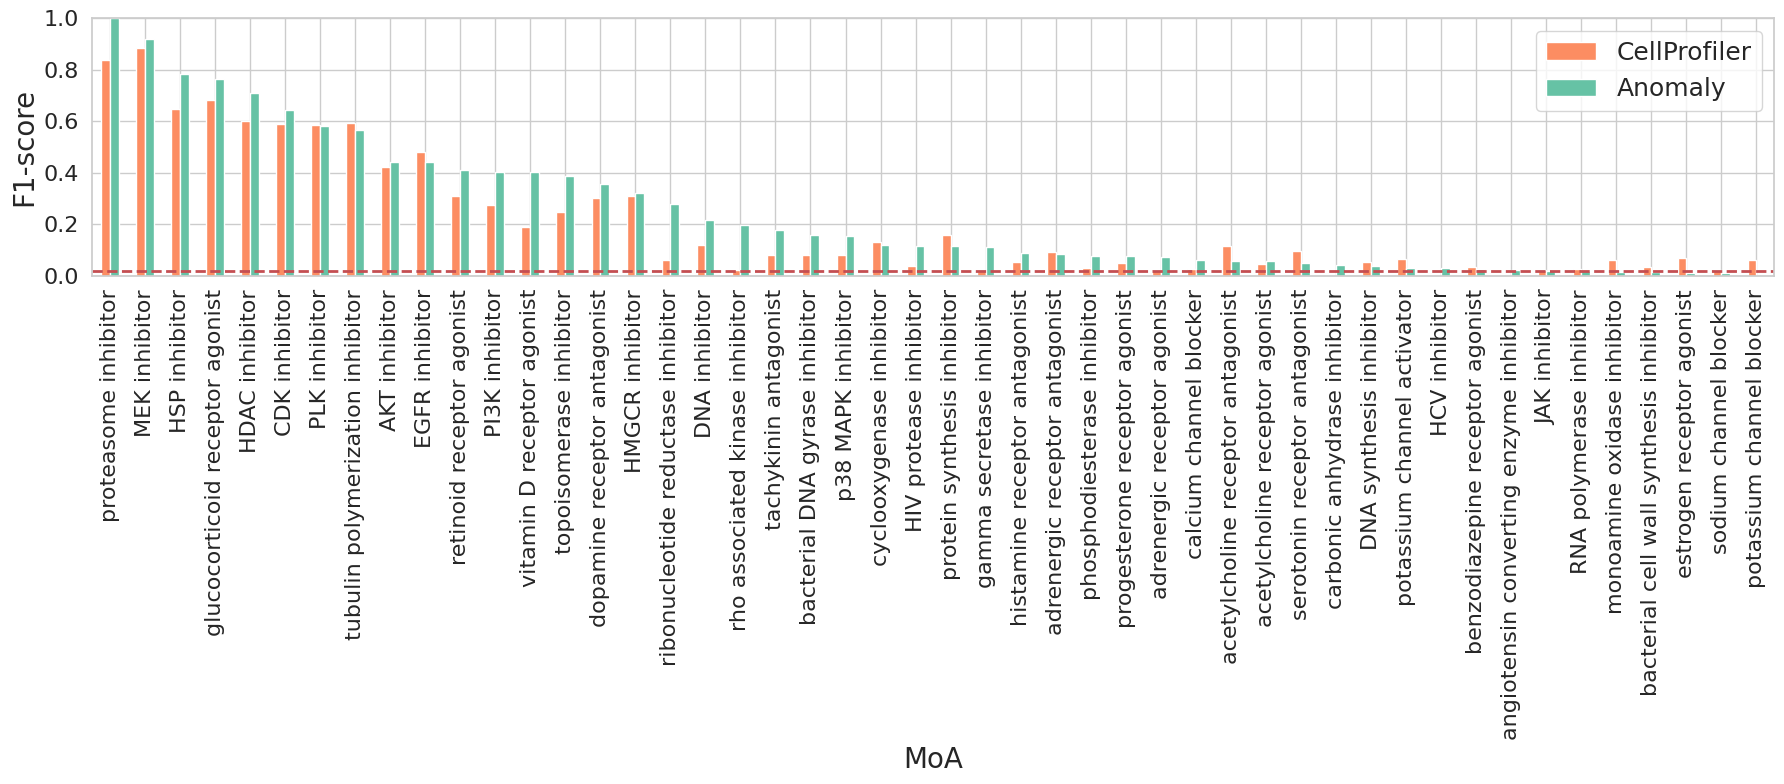

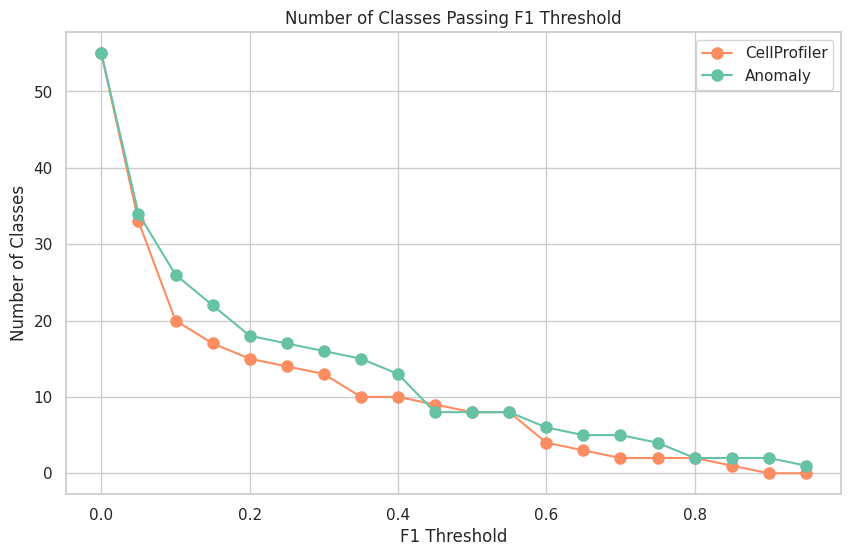

running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 55
number of classes with F1-score higher than random: 55


<Figure size 640x480 with 0 Axes>

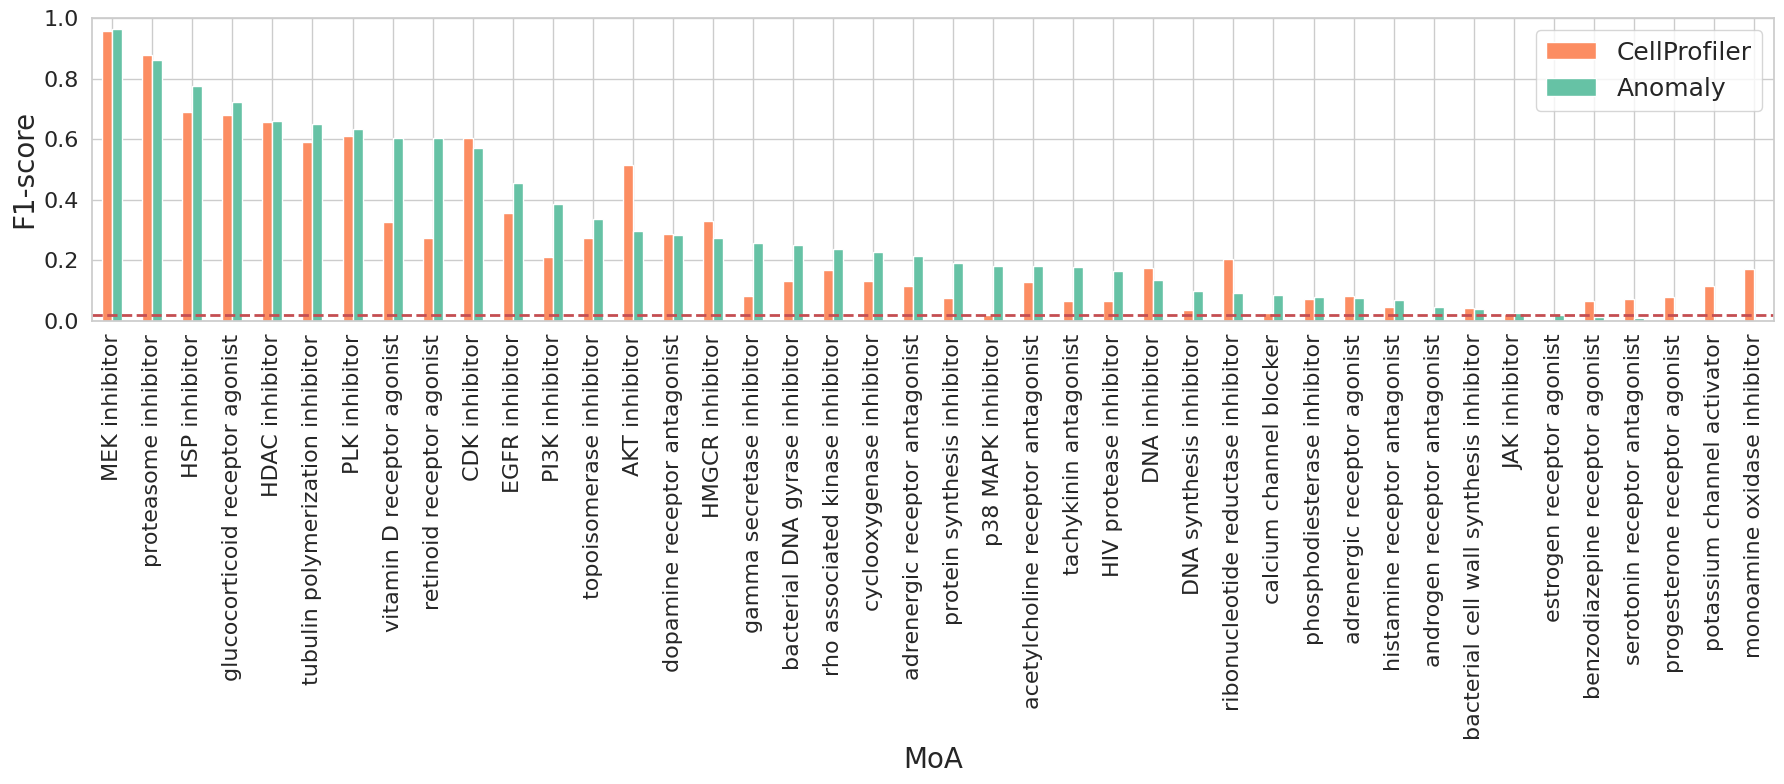

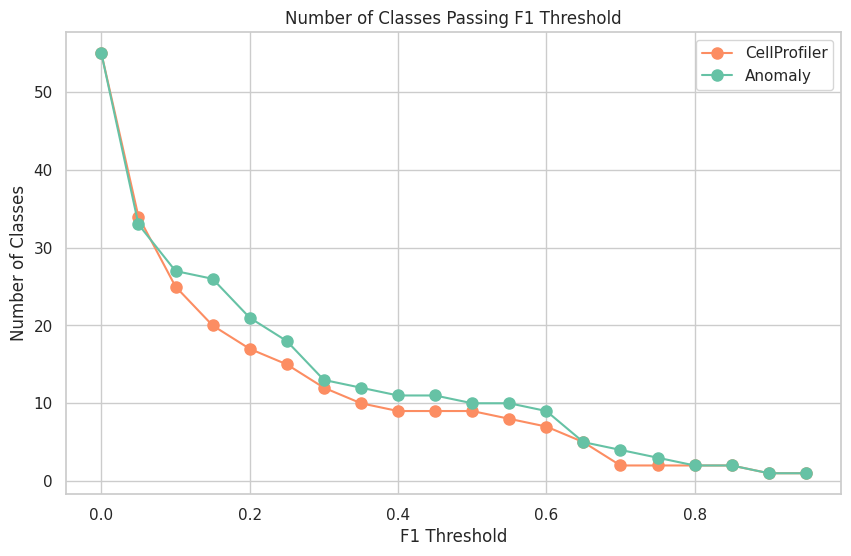

<Figure size 640x480 with 0 Axes>

In [385]:
from sklearn.metrics import classification_report
from utils.global_variables import methods_colors_list_for_moa

with_fusion = False

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['CellProfiler'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['Anomaly'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    if with_fusion:
        report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4=report_clss3[['f1-score-raw','f1-score']]
        
    report_clss4=report_clss4.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']

    rand_f1_score = (1/n_classes)/ ( (1-1/n_classes) + 1/n_classes + 1/n_classes)
    print(f'n_classes: {len(report_clss4)}')

    report_clss5 = report_clss4[(report_clss4['CellProfiler']>=rand_f1_score) | (report_clss4['Anomaly']>=rand_f1_score)]
    print(f'number of classes with F1-score higher than random: {len(report_clss4)}')

    # ax = report_clss4.plot.bar(rot=90,figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    ax = report_clss5.plot.bar(rot=90,figsize=(int(n_classes/3),8),fontsize=16,linewidth=1)

    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    # plt.title(f'{dataset} class specific F1-scores ({model})')
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('F1-score', fontsize=20)
    plt.xlabel('MoA', fontsize=20)
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = True
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir, f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname}.png'), dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [386]:
n_classes

55

In [387]:
metric = 'f1-score'
# f1_thresh = 0.1
print(f'f1-score threshold: {rand_f1_score}')
# (report_clss_raw[metric]>rand_f1_score).sum(), (report_clss_ae_err[metric]>rand_f1_score).sum(),(report_clss_fuse[metric]>rand_f1_score).sum()
(report_clss_raw[metric]>rand_f1_score).sum(), (report_clss_ae_err[metric]>rand_f1_score).sum()

f1-score threshold: 0.01785714285714286


(43, 40)

In [388]:
metric = 'f1-score'
f1_thresh = 0.2
print(f'f1-score threshold: {f1_thresh}')
# (report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()

f1-score threshold: 0.2


(17, 24)

In [389]:
metric = 'recall'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()
# (report_clss_fuse[metric]>f1_thresh).sum()

(15, 23)

In [390]:
metric = 'precision'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum()
# ,(report_clss_fuse[metric]>f1_thresh).sum()


(21, 25)

In [391]:
res_filename

'pred_moa_res_all'

In [392]:
moa_csv_dirname_ref, ref_exp_suffix, ref_filter_abrv = get_moa_dirname(profile_type, by_dose, ref_filter_groups, folds, nSamplesMOA, normalize_by_all)

exp_results_to_csv(exp_dir, moa_csv_dirname_ref, filename=res_filename)


save_dir = os.path.join(moa_exp_dir,moa_csv_dirname_ref)
# fig_dir = f'{moa_csv_dirname_ref}/figures/'
# os.makedirs(save_dir,exist_ok=True)
os.makedirs(fig_dir,exist_ok=True)

# moa_exp_dir, exp_suffix, filter_abrv = get_moa_dirname(profile_type, by_dose, ref_filter_groups, folds, nSamplesMOA, normalize_by_all)
# ref_save_dir = os.path.join(save_dir,moa_exp_dir)
moa_csv_path=os.path.join(save_dir,f'pred_moa_res_all.xlsx')
saved_scores_orig=pd.read_excel(moa_csv_path, sheet_name=None)

sgkf_keys_all = saved_scores_orig.keys()

sgkf_keys = []
if tune:
    sgkf_keys = [s for s in sgkf_keys_all if '-t'  in s]
    if tune_all_folds:
        sgkf_keys = [s for s in sgkf_keys_all if '-ta'  in s]
    else:
        sgkf_keys = [s for s in sgkf_keys_all if not '-ta'  in s]
else:
    sgkf_keys = [s for s in sgkf_keys_all if not '-t'  in s]
sgkf_keys


# for key in saved_scores_orig.keys():
    # print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
# saved_scores_cdrpbio['raw_a-lr'].shape

['Anomaly-lr-ta',
 'Anomaly-mlp-ta',
 'CellProfiler-lr-ta',
 'CellProfiler-mlp-ta',
 'fuse-lr-ta',
 'fuse-mlp-ta']

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly_ref', 'CellProfiler_ref', 'Fusion_ref', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 46
number of classes with F1-score higher than random: 46


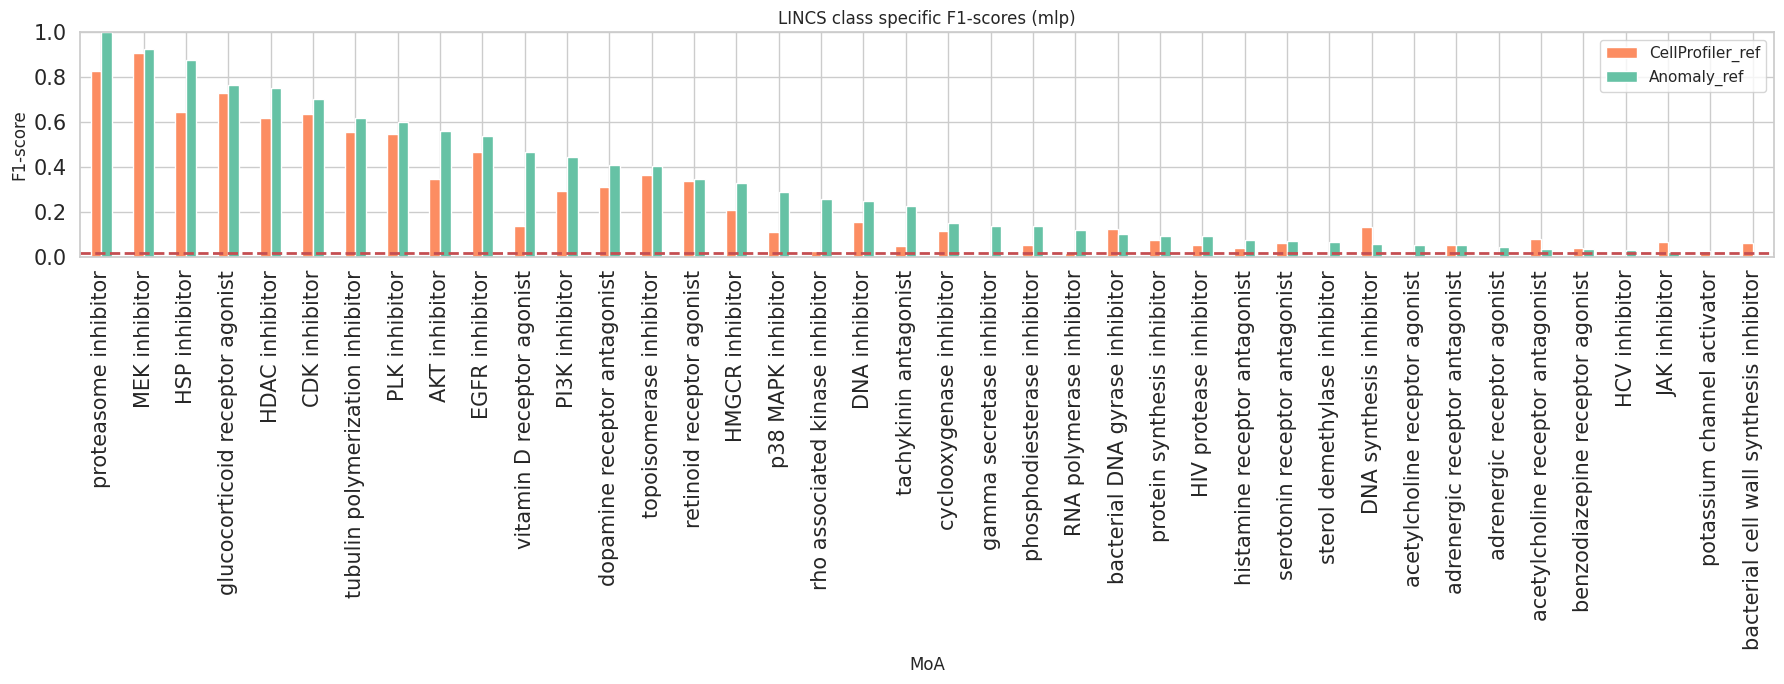

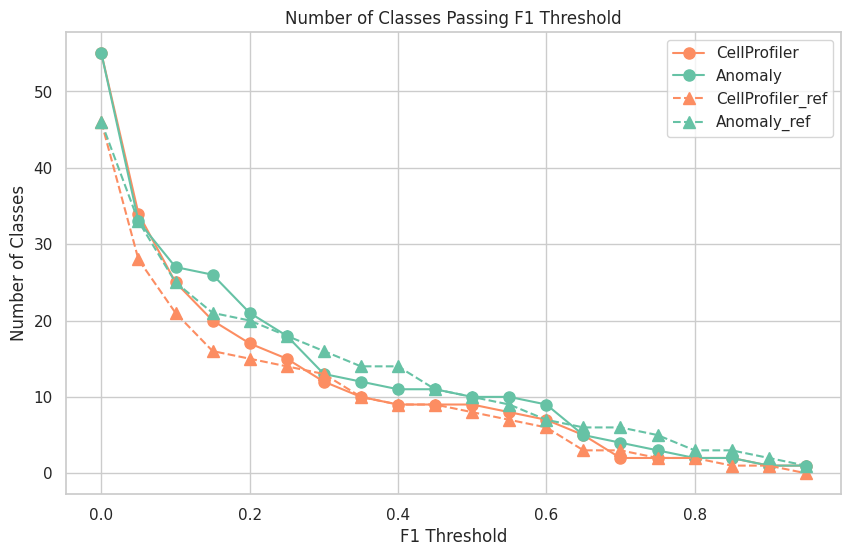

running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly_ref', 'CellProfiler_ref', 'Fusion_ref', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 46
number of classes with F1-score higher than random: 46


<Figure size 640x480 with 0 Axes>

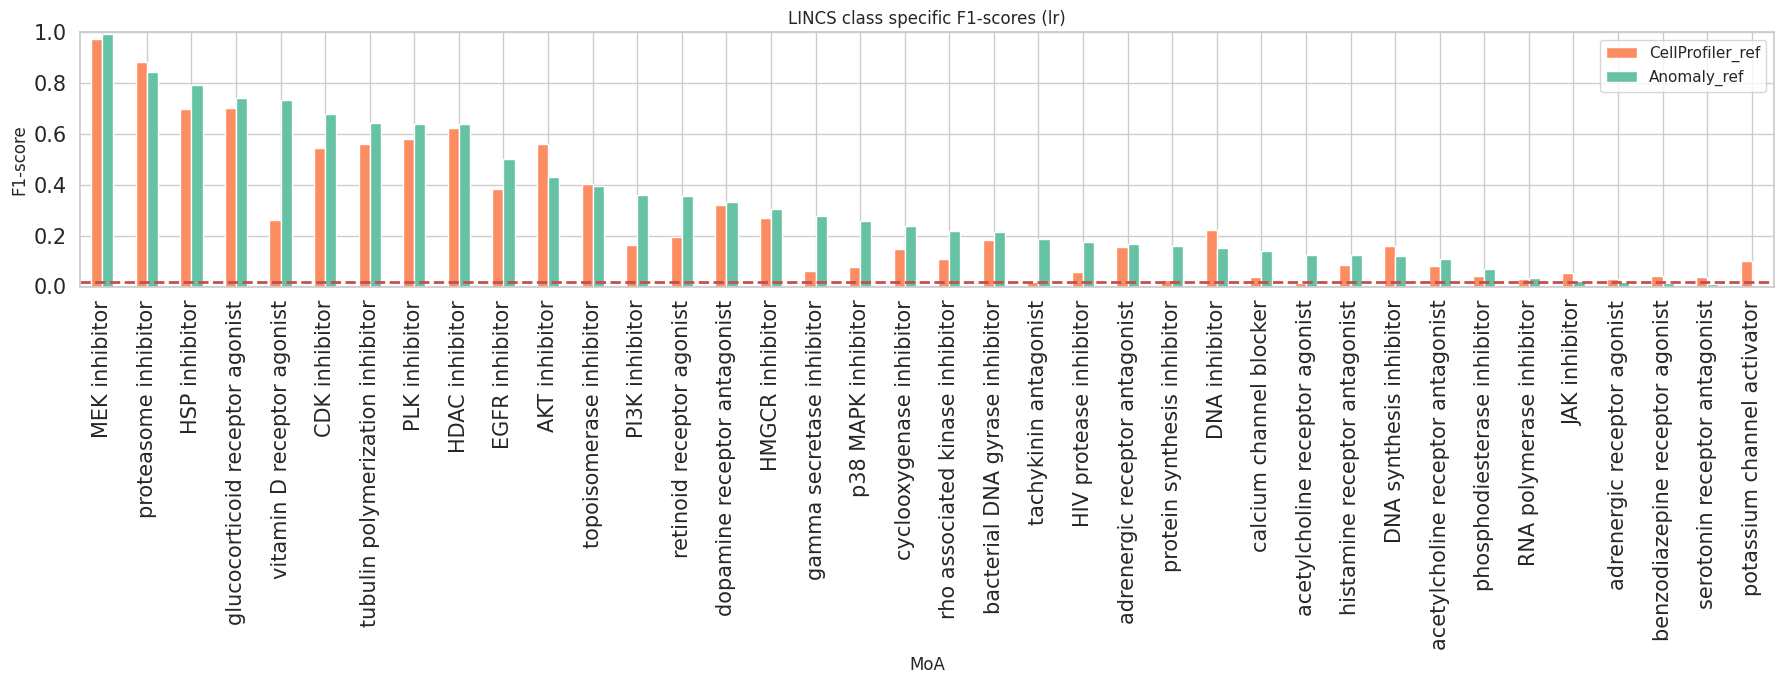

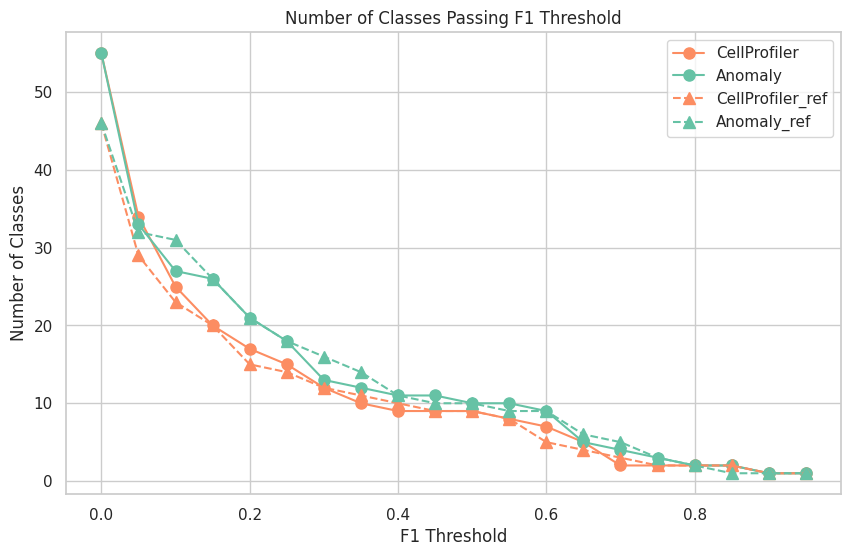

<Figure size 640x480 with 0 Axes>

In [393]:
with_fusion = False
show_both_new_and_ref = False

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        # scores_model = saved_scores_cdrpbio[k]
        # scores[rep] = scores_model['CP']

        scores_model_ref = saved_scores_orig[k]
        scores[f'{rep}_ref'] = scores_model_ref['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model_ref['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model_ref['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model_ref['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())

    # # 2. reformat scores to be able to use classification report
    n_classes_orig = len(scores_mlp['Metadata_moa_num'].unique())

    scor_vals_raw_ref=scores_mlp['CellProfiler_ref'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err_ref=scores_mlp['Anomaly_ref'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    # report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    # report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    report_clss_ae_err_ref=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err_ref.values,output_dict=True)).transpose()
    report_clss_raw_ref=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw_ref.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err_ref['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err_ref.index[0:n_classes_orig]:
        report_clss_ae_err_ref.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err_ref[0:n_classes_orig]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    # report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    report_clss3['f1-score-raw-ref']=report_clss_raw_ref.loc[report_clss3.index]['f1-score'].values

    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4_ref=report_clss3[['f1-score-raw-ref','f1-score']]
        
    report_clss4_ref=report_clss4_ref.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly_ref','f1-score-fuse':'Fusion', 'f1-score-raw-ref':'CellProfiler_ref', 'f1-score-ae_err-ref':'Anomaly_ref'})
    report_clss4_ref.index=report_clss3['MoA']

    if show_both_new_and_ref:
        report_class_4_for_ref_plot = report_clss4[report_clss4.index.isin(report_clss4_ref.index)]
        # concat the two dataframes
        report_clss4_ref = pd.concat([report_clss4_ref, report_class_4_for_ref_plot], axis=1)

    rand_f1_score_ref = (1/n_classes_orig)/ ( (1-1/n_classes_orig) + 1/n_classes_orig + 1/n_classes_orig)
    print(f'n_classes: {len(report_clss4_ref)}')
    report_clss5_ref = report_clss4_ref[(report_clss4_ref['CellProfiler_ref']>=rand_f1_score_ref) | (report_clss4_ref['Anomaly_ref']>=rand_f1_score_ref)]
    print(f'number of classes with F1-score higher than random: {len(report_clss4_ref)}')

    # ax = report_clss4_ref.plot.bar(rot=90,figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    ax = report_clss5_ref.plot.bar(rot=90,figsize=(int(n_classes/3),7),fontsize=15,linewidth=1)

    # highlight the x labels of classes that are only in new and not in ref
    if show_both_new_and_ref:
        new_classes = list(set(report_clss_ae_err['MoA']) - set(report_clss_ae_err_ref['MoA']))
        for i, label in enumerate(ax.get_xticklabels()):
            print(label.get_text())
            if label.get_text() in new_classes:
                # print(label.get_text())
                label.set_color('red')
                label.set_fontweight('bold')
        

    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    plt.title(f'{dataset} class specific F1-scores ({model})')

    plt.ylabel('F1-score')
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}_vs_ref.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = True
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', linestyle='solid', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o' , linestyle='solid', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        plt.plot(x, [len(report_clss4_ref[report_clss4_ref['CellProfiler_ref'] >= f1_threshold]) for f1_threshold in x], marker='^', linestyle='dashed', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler_ref')
        plt.plot(x, [len(report_clss4_ref[report_clss4_ref['Anomaly_ref'] >= f1_threshold]) for f1_threshold in x], marker='^', linestyle='dashed', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly_ref')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir,f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname} vs. ref.png'),dpi=500)


In [394]:
#classes that are in represetation 1 but not in representation 2
set(report_clss_ae_err.index) - set(report_clss_ae_err_ref.index)

# classes that are in representation 1 but not in representation 2 by MoA label
new_classes = list(set(report_clss_ae_err['MoA']) - set(report_clss_ae_err_ref['MoA']))
new_classes

['carbonic anhydrase inhibitor',
 'progesterone receptor agonist',
 'nucleoside reverse transcriptase inhibitor',
 'angiotensin converting enzyme inhibitor',
 'monoamine oxidase inhibitor',
 'potassium channel blocker',
 'ribonucleotide reductase inhibitor',
 'androgen receptor antagonist',
 'PKC inhibitor']

running for mlp
['Anomaly-mlp-ta', 'CellProfiler-mlp-ta', 'fuse-mlp-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 55
number of classes with F1-score higher than random: 55


running for lr
['Anomaly-lr-ta', 'CellProfiler-lr-ta', 'fuse-lr-ta']
Index(['Anomaly', 'CellProfiler', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
n_classes: 55
number of classes with F1-score higher than random: 55


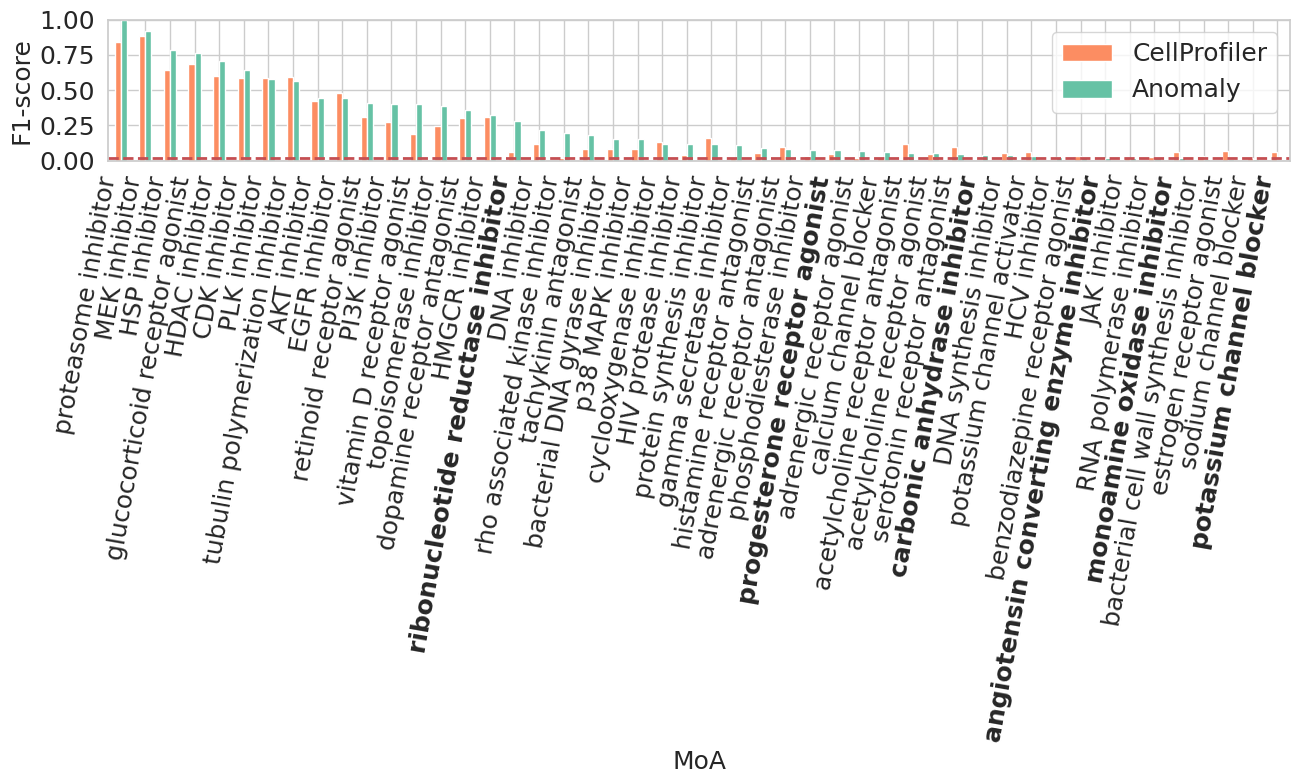

<Figure size 1000x600 with 0 Axes>

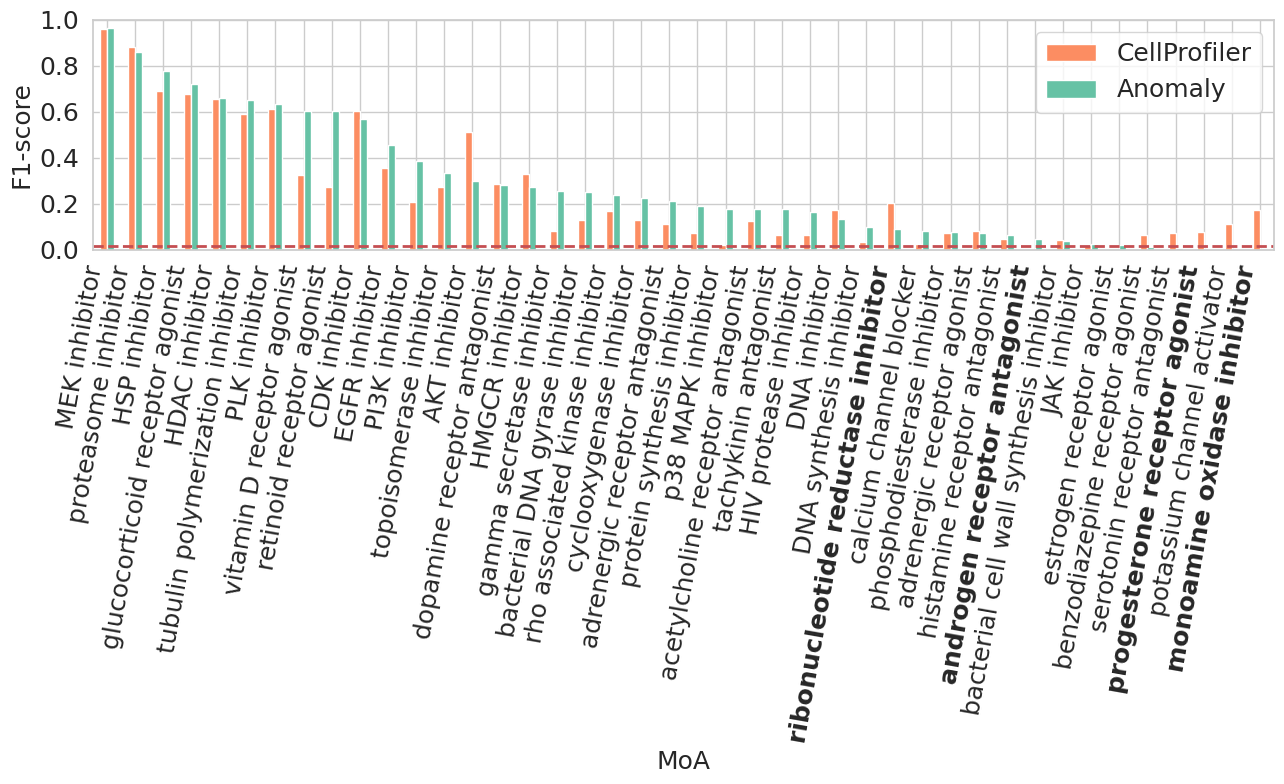

<Figure size 1000x600 with 0 Axes>

In [395]:
from sklearn.metrics import classification_report
from utils.global_variables import methods_colors_list_for_moa

with_fusion = False
added_show_thresh_val = 0

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:

    print(f'running for {model}')
    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'Anomaly' in k:
            rep = 'Anomaly'
        elif 'CellProfiler' in k:
            rep = 'CellProfiler'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['CellProfiler'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['Anomaly'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    if with_fusion:
        scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    if with_fusion:
        report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    if with_fusion:
        report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    if with_fusion:
        report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]
    else:
        report_clss4=report_clss3[['f1-score-raw','f1-score']]
        
    report_clss4=report_clss4.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']

    rand_f1_score = (1/n_classes)/ ( (1-1/n_classes) + 1/n_classes + 1/n_classes)
    thresh = rand_f1_score + added_show_thresh_val
    print(f'n_classes: {len(report_clss4)}')
    report_clss5 = report_clss4[(report_clss4['CellProfiler']>=thresh) | (report_clss4['Anomaly']>=thresh)]
    print(f'number of classes with F1-score higher than random: {len(report_clss4)}')

    # ax = report_clss4.plot.bar(figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    if dataset == 'CDRP-bio':
        figsize_v = int(n_classes/2.5)
    else:
        if nSamplesMOA ==9:
            figsize_v = int(n_classes/3.5)
        else:
            figsize_v = int(n_classes/4)
    ax = report_clss5.plot.bar(figsize=(figsize_v,8),fontsize=18,linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha='right')
    for i, label in enumerate(ax.get_xticklabels()):
        # print(label.get_text())
        if label.get_text() in new_classes:
            # print(label.get_text())
            # label.set_color('blue')
            label.set_fontweight('bold')
    
    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(figsize=(5,6.5),fontsize=15)

    # plt.title(f'{dataset} class specific F1-scores ({model})')
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('F1-score', fontsize=18)
    plt.xlabel('MoA', fontsize=18)
    ax.set_ylim([0,1])
    ax.axhline(y=rand_f1_score,linestyle='--',color='r',linewidth=2)
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_dirname}.png')
    plt.savefig(save_path,dpi=500)
    # plt.close()

    # a graph showing the number of classes that pass the F1 threshold vs. the F1 threshold
    plt.figure(figsize=(10, 6))
    x = np.arange(0, 1, 0.05)

    do_plot = False
    if do_plot:
        # Plotting the graph
        plt.plot(x, [len(report_clss4[report_clss4['CellProfiler'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[0], label='CellProfiler')
        plt.plot(x, [len(report_clss4[report_clss4['Anomaly'] >= f1_threshold]) for f1_threshold in x], marker='o', markersize=8, color=methods_colors_list_for_moa[1], label='Anomaly')
        # plt.axhline(y=1/n_classes, color='red', linestyle='--')

        # Customize the plot
        plt.xlabel('F1 Threshold')
        plt.ylabel('Number of Classes')
        plt.title('Number of Classes Passing F1 Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(fig_dir, f'num_classes_passing_f1_threshold_{model}_{moa_csv_dirname}.png'), dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [396]:
top_10_classes = report_clss4.sort_values(by='Anomaly', ascending=False).head(10)
list(top_10_classes.index)

['MEK inhibitor',
 'proteasome inhibitor',
 'HSP inhibitor',
 'glucocorticoid receptor agonist',
 'HDAC inhibitor',
 'tubulin polymerization inhibitor',
 'PLK inhibitor',
 'vitamin D receptor agonist',
 'retinoid receptor agonist',
 'CDK inhibitor']

In [397]:
print('Number of classes in representation 1 but not in representation 2: ', len(new_classes))
print('number of classes in with new filtering: ', n_classes)
print('number of classes in old filtering: ', n_classes_orig)

Number of classes in representation 1 but not in representation 2:  9
number of classes in with new filtering:  55
number of classes in old filtering:  46


In [398]:
f1_thresh = rand_f1_score
print(f'number of classes with F1 higher than {f1_thresh} for representation AE: {(report_clss_ae_err["f1-score"][:n_classes]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler: {(report_clss_raw["f1-score"][:n_classes]>f1_thresh).sum()}')
f1_thresh = rand_f1_score_ref
print(f'number of classes with F1 higher than {f1_thresh} for representation AE ref: {(report_clss_ae_err_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler ref: {(report_clss_raw_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')


number of classes with F1 higher than 0.01785714285714286 for representation AE: 37
number of classes with F1 higher than 0.01785714285714286 for representation CellProfiler: 40
number of classes with F1 higher than 0.021276595744680847 for representation AE ref: 34
number of classes with F1 higher than 0.021276595744680847 for representation CellProfiler ref: 36


In [399]:
# print number of classes with F1 higher than 0.2 for all representations
f1_thresh = 0.15
print(f'number of classes with F1 higher than {f1_thresh} for representation AE: {(report_clss_ae_err["f1-score"][:n_classes]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler: {(report_clss_raw["f1-score"][:n_classes]>f1_thresh).sum()}')

print(f'number of classes with F1 higher than {f1_thresh} for representation AE ref: {(report_clss_ae_err_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')
print(f'number of classes with F1 higher than {f1_thresh} for representation CellProfiler ref: {(report_clss_raw_ref["f1-score"][:n_classes_orig]>f1_thresh).sum()}')


number of classes with F1 higher than 0.15 for representation AE: 26
number of classes with F1 higher than 0.15 for representation CellProfiler: 20
number of classes with F1 higher than 0.15 for representation AE ref: 26
number of classes with F1 higher than 0.15 for representation CellProfiler ref: 20


In [400]:
report_clss_ae_err['f1-score']['weighted avg'], report_clss_raw['f1-score']['weighted avg'], report_clss_ae_err_ref['f1-score']['weighted avg'], report_clss_raw_ref['f1-score']['weighted avg']

(0.21965490642525778,
 0.1889664558805035,
 0.26092131048526496,
 0.2154084157607318)

In [401]:
# print F1 improvement for AE vs. CellProfiler per class
f1_improvement = report_clss_ae_err['f1-score'] - report_clss_raw['f1-score']
f1_improvement.mean(), f1_improvement.median(), f1_improvement.std()
# f1_improvement
f1_improvement_dict = {}
for i in range(0, len(f1_improvement)):
    f1_improvement_dict[report_clss_ae_err.MoA[i]] = f1_improvement[i]
    # print(f'F1 improvement for class {report_clss_ae_err.MoA[i]}: {f1_improvement[i]}')
f1_improvement_df = pd.DataFrame(f1_improvement_dict.items(), columns=['MoA', 'F1 improvement']).sort_values(by='F1 improvement', ascending=False)
f1_improvement_df.to_csv(os.path.join(fig_dir, 'f1_improvement_ae_vs_cp.csv'), index=False)
f1_improvement_df

,MoA,F1 improvement
44,retinoid receptor agonist,0.329682
54,vitamin D receptor agonist,0.276851
13,PI3K inhibitor,0.176840
32,gamma secretase inhibitor,0.173936
37,p38 MAPK inhibitor,0.160070
23,bacterial DNA gyrase inhibitor,0.121854
43,protein synthesis inhibitor,0.115115
51,tachykinin antagonist,0.110355
5,EGFR inhibitor,0.101266
8,HIV protease inhibitor,0.098275


In [402]:
scores_mlp['Metadata_moa_with_n'].unique()

array(['calcium channel blocker (n=12)', 'HSP inhibitor (n=5)',
       'CC chemokine receptor antagonist (n=5)',
       'histamine receptor antagonist (n=18)',
       'tubulin polymerization inhibitor (n=8)',
       'adrenergic receptor antagonist (n=22)',
       'dopamine receptor antagonist (n=14)',
       'progesterone receptor agonist (n=6)',
       'sodium channel blocker (n=9)', 'HIV protease inhibitor (n=5)',
       'serotonin receptor antagonist (n=12)',
       'glucocorticoid receptor agonist (n=14)',
       'benzodiazepine receptor agonist (n=8)',
       'bacterial cell wall synthesis inhibitor (n=9)',
       'serotonin receptor agonist (n=10)',
       'estrogen receptor agonist (n=6)',
       'cyclooxygenase inhibitor (n=21)',
       'acetylcholine receptor antagonist (n=20)',
       'bacterial DNA gyrase inhibitor (n=9)',
       'carbonic anhydrase inhibitor (n=5)',
       'androgen receptor antagonist (n=7)',
       'acetylcholine receptor agonist (n=6)',
       'angiotens

In [403]:
# produce figure only for those classes that are only in representation 1
report_clss_ae_err[~report_clss_ae_err.index.isin(report_clss_ae_err.index)]


,precision,recall,f1-score,support,MoA


In [404]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
# ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
# ax.set_ylim([0,1])
# plt.title('MoA class specific F1-scores')
# plt.tight_layout()

In [405]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']/10


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [406]:
scores_mlp

,Anomaly,CellProfiler,Fusion,Metadata_moa_num,Metadata_moa_with_n,Metadata_MoA
0,25,27,27,26,calcium channel blocker (n=12),calcium channel blocker
1,19,15,7,10,HSP inhibitor (n=5),HSP inhibitor
2,47,20,47,1,CC chemokine receptor antagonist (n=5),CC chemokine receptor antagonist
3,20,24,29,34,histamine receptor antagonist (n=18),histamine receptor antagonist
4,53,53,53,53,tubulin polymerization inhibitor (n=8),tubulin polymerization inhibitor
...,...,...,...,...,...,...
4675,25,24,24,52,topoisomerase inhibitor (n=13),topoisomerase inhibitor
4676,50,50,50,41,progesterone receptor agonist (n=6),progesterone receptor agonist
4677,44,28,28,39,potassium channel activator (n=6),potassium channel activator
4678,38,30,18,30,dopamine receptor antagonist (n=14),dopamine receptor antagonist


In [407]:
report_clss2

,precision,recall,f1-score,support,MoA,n_samples
0,0.458333,0.220000,0.297297,50,AKT inhibitor,5.0
1,0.000000,0.000000,0.000000,50,CC chemokine receptor antagonist,5.0
2,0.684211,0.487500,0.569343,80,CDK inhibitor,8.0
3,0.133333,0.133333,0.133333,60,DNA inhibitor,6.0
4,0.121951,0.083333,0.099010,60,DNA synthesis inhibitor,6.0
5,0.556701,0.385714,0.455696,140,EGFR inhibitor,14.0
6,0.000000,0.000000,0.000000,80,HCV inhibitor,8.0
7,0.676190,0.645455,0.660465,110,HDAC inhibitor,11.0
8,0.194444,0.140000,0.162791,50,HIV protease inhibitor,5.0
9,0.300000,0.250000,0.272727,60,HMGCR inhibitor,6.0


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


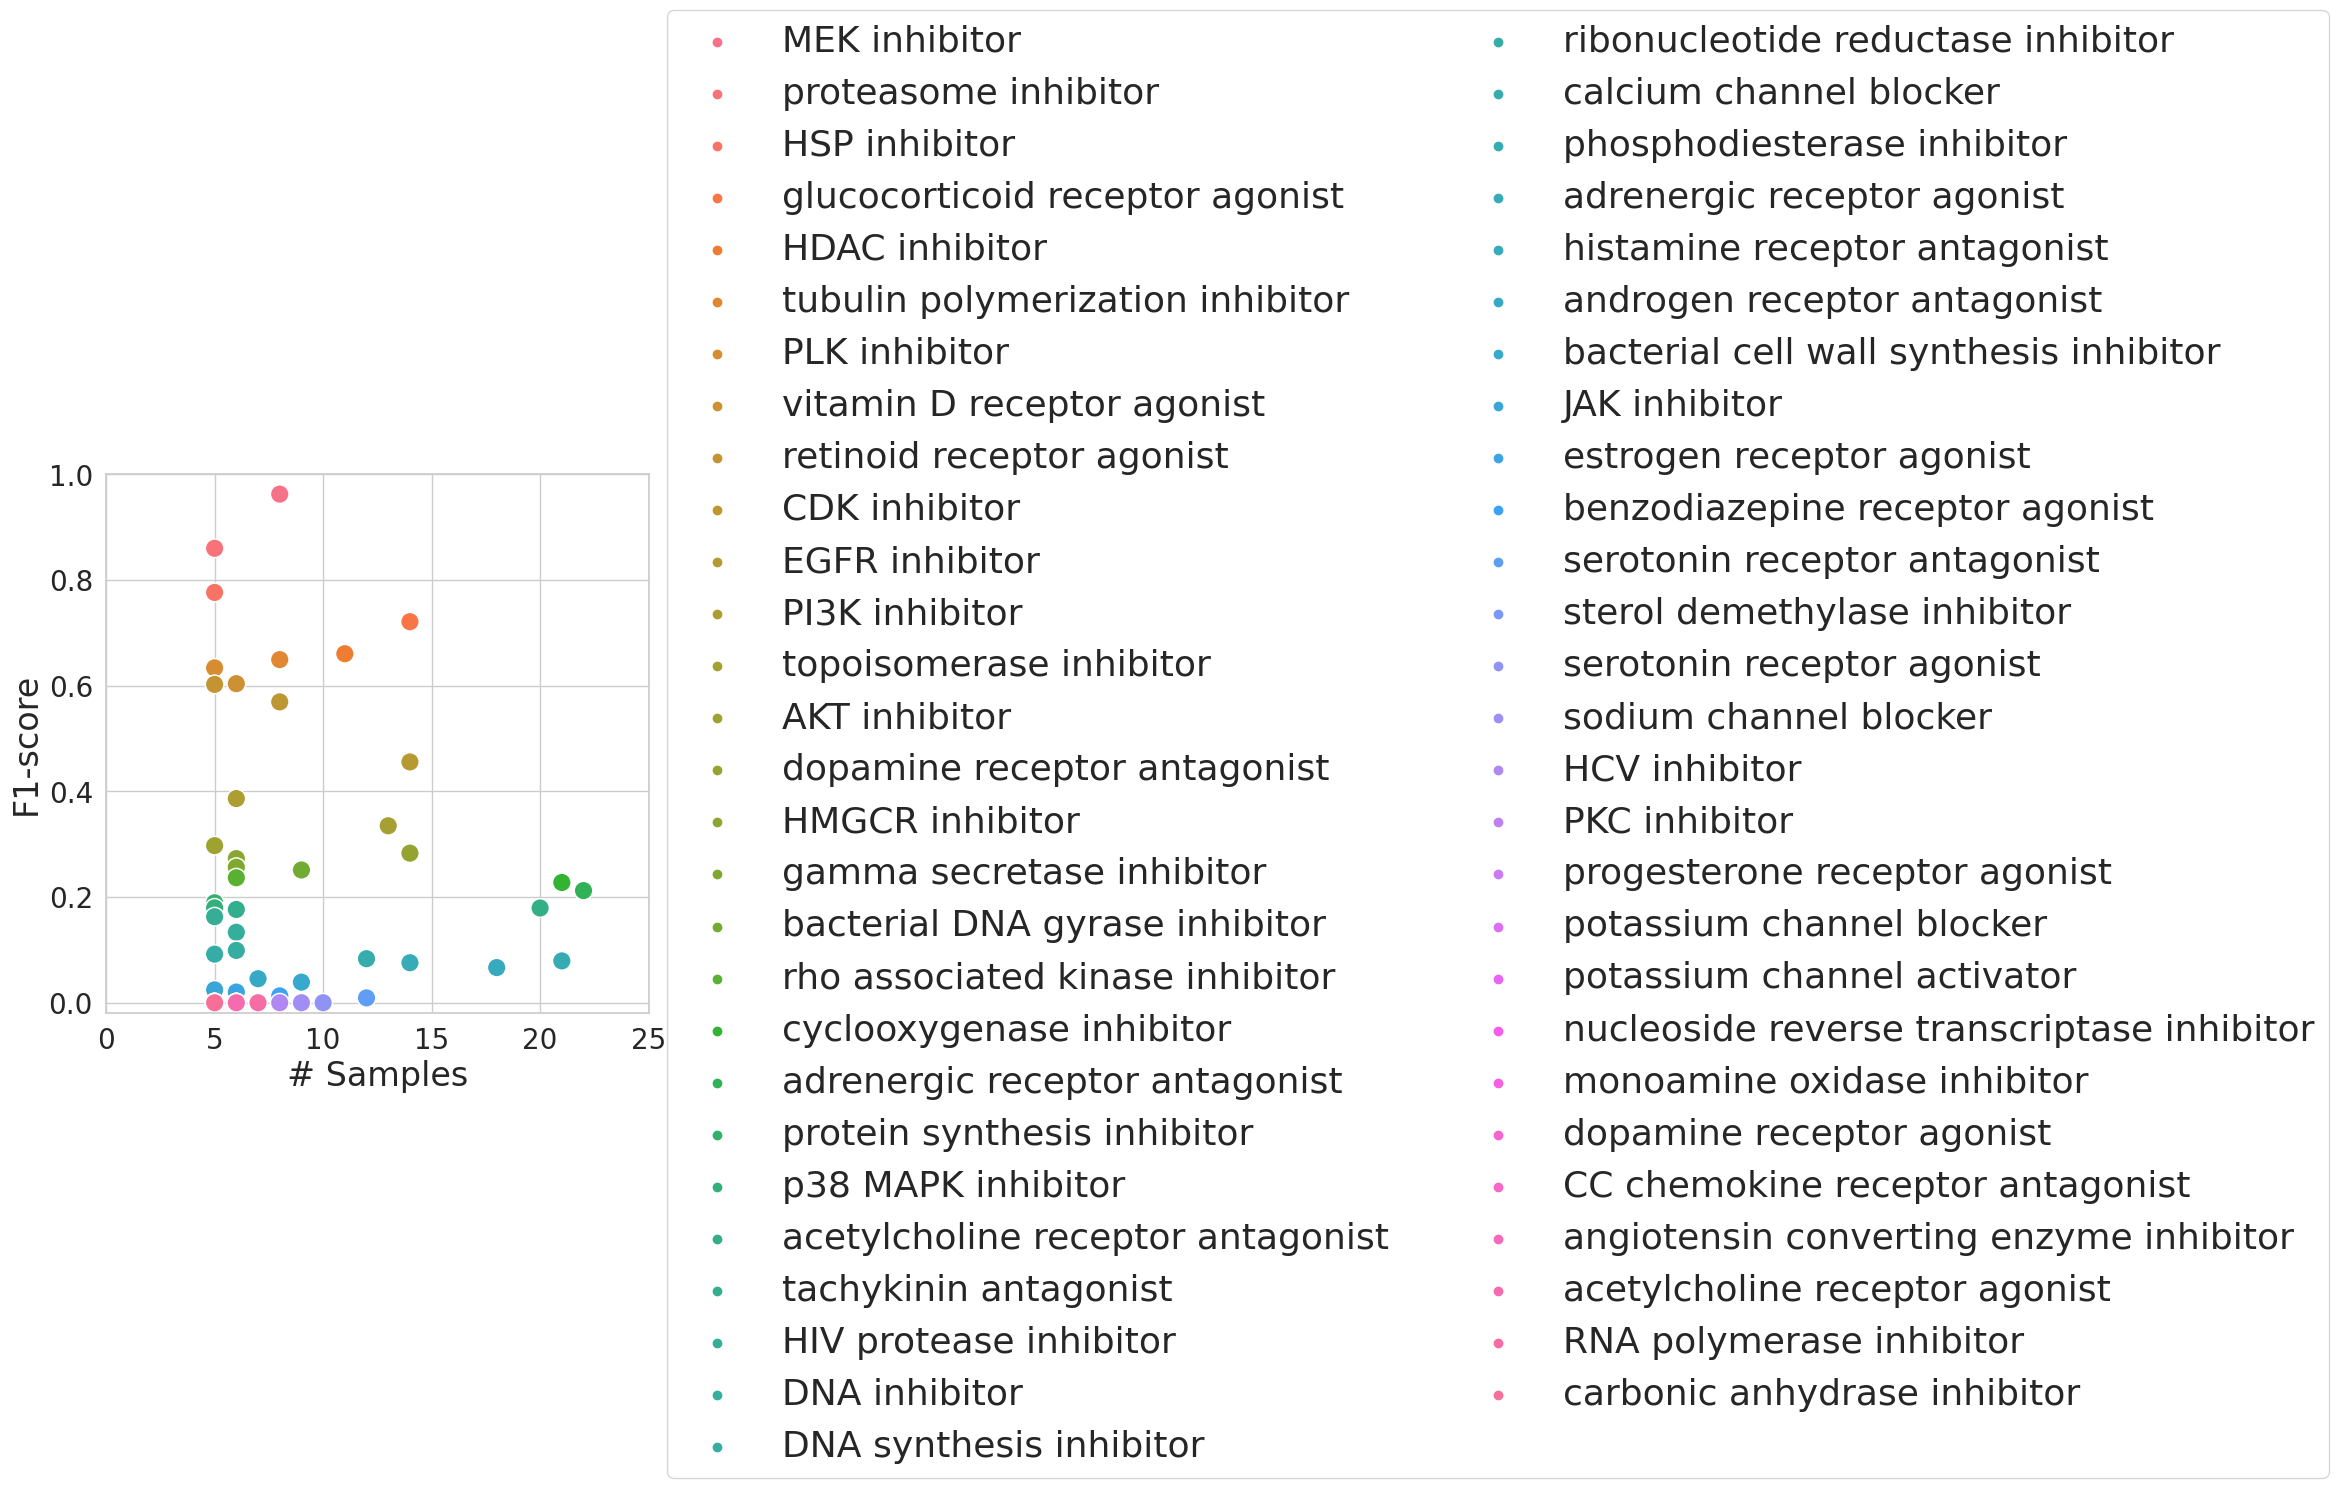

In [408]:


import matplotlib.style as style
style.use('seaborn-colorblind')
report_clss2=report_clss2.sort_values(by='f1-score',ascending=False)
# if dataset == 'CDRP-bio':
    # plt.figure(figsize=(3,8))
# else:
plt.figure(figsize=(7,7))
# plt.figure(figsize=(6,8))
sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True, s= 180)

plt.xlabel('# Samples', fontsize=24)
plt.ylabel('F1-score', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=20)
if dataset == 'CDRP-bio':
    # plt.legend(loc='upper right', fontsize=7)
    # plt.xlabel('# Samples', fontsize=18)
    # plt.ylabel('F1-score', fontsize=18)
    # plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=26)

    plt.xlim([0,20])
    plt.ylim([-0.02,1])
else:
    # plt.legend(loc='upper right', fontsize=5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=26)
    plt.xlim([0,25])
    plt.ylim([-0.02,1])
plt.savefig(os.path.join(fig_dir, f'moa_class_scatter_{model}_{moa_csv_dirname}.png'), dpi=500, bbox_inches="tight")
# plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [409]:
# print F1 scores for ae_err and raw
report_clss_ae_err['f1-score']['weighted avg'], report_clss_raw['f1-score']['weighted avg'], report_clss_ae_err_ref['f1-score']['weighted avg'], report_clss_raw_ref['f1-score']['weighted avg']

(0.21965490642525778,
 0.1889664558805035,
 0.26092131048526496,
 0.2154084157607318)

In [410]:
from sklearn.metrics import classification_report
# scores_mlp=saved_scores['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
scores_mlp=saved_scores_cdrpbio['CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))

# report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(8,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

KeyError: 'CDRP-bio-nvs-filtmlp-ht-5'

In [ ]:
profiles[profileTypes[0]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.264622,0.807081,-0.386414,0.081742,-0.273633,-2.066935,0.605935,...,1.065557,0.131064,-1.780924,0.405090,1.625192,1.789100,0.040616,0.067822,1.247974,1.025713
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.329668,0.703280,-0.077705,0.813642,-1.068426,-1.876976,-0.087118,...,0.516663,1.185075,-1.414009,0.065854,-0.096426,2.465919,0.269154,0.652037,0.366176,-1.379910
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,0.401566,0.924250,-1.012552,0.640234,-0.719023,-2.989688,-1.269140,...,2.081157,1.921284,-1.346027,-0.159600,-0.254842,3.531163,0.207268,1.578023,1.173281,-0.395136
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.041800,0.965873,-0.288522,0.117821,-0.460816,-0.497151,0.055651,...,0.207931,0.731051,-0.619767,-0.131630,-0.318810,1.110389,0.108630,0.420290,-0.579276,-1.318331
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.349513,0.409721,-0.370522,0.721858,-0.603690,-2.321964,0.571849,...,1.334717,0.508390,-1.898190,0.381566,0.723224,2.703150,0.607234,0.616687,1.212654,-0.990831


In [ ]:
profiles[profileTypes[1]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.799937,0.114691,-0.517638,0.028612,-0.931846,0.764567,1.750010,...,-1.606169,-1.959599,0.072195,1.085400,1.849980,-0.233558,1.564405,0.178441,-0.926234,-0.710648
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.418703,0.278070,0.127559,-0.365288,-0.566421,0.510057,-0.523591,...,0.357398,-0.364599,0.350724,0.171595,-0.508193,-0.193964,0.567399,0.139890,-0.116119,-0.413985
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,-0.048316,-0.956267,-3.264594,-0.279963,-0.752487,-1.795259,-2.167885,...,0.210484,1.739892,-3.448300,-2.076596,0.937424,1.926309,1.915977,-1.318658,0.730327,-4.498349
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.046405,0.272033,0.127239,0.094547,-0.407864,0.007637,-0.043617,...,0.237888,0.679389,-2.533574,-0.018369,-0.253812,-0.340848,-0.210730,0.840703,0.263274,0.051612
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.050980,-0.689335,0.082826,0.461509,-1.094516,0.731555,0.968479,...,0.195945,-1.925705,0.792649,0.476247,1.721735,-0.509423,0.371926,0.635822,-1.512223,0.049279


In [ ]:

# report_clss
from sklearn.metrics import classification_report
scores_mlp=saved_scores_cdrpbio['CDRP-bio-Raw-filtmlp-ht-sgkf-10f']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

# report_clss_cp.loc[report_clss3.index]['f1-score']
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Early Fusion'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4[report_clss4["Early Fusion"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)
plt.title('MoA class specific F1-scores\n CDRP-bio')
ax.set_ylim([0,1])
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

# if 1:
#     source_data_add='../Figs_Source_Data.xlsx'
#     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

#     # fig.tight_layout()
#     plt.savefig('fig4c_1.pdf',dpi=500)

KeyError: 'CDRP-bio-Raw-filtmlp-ht-sgkf-10f'